# Alz specific gene analysis
A recent research on Alzheimer disease at 2019 identified 198 unique genes of interest from both table 1 and supplementary table 13. They are

34 genes from 
   >Table 1: Significantly associated regions identified in the GWAS of AD case-control status, AD-by-proxy phenotype, and meta-analysis

192 genes from 
   >Supplementary Table 13: Genes implicated by positional mapping, eQTL or chromatin interaction mapping of significant GWAS SNPs.

Among them, 6 genes in Table 1 are not covered in S_Table 13, making a total of 198 genes.

This analysis take these regions, cross reference them with the genes that were sequenced in the ROSMAP data set, and then compute the weight and Association stats for it. 


## Method
For details on how data was generated please see Alz_specific_gene_analysis_data_generation.ipynb


## Result

All data used in the followed up analysis are organized into one tibble with the following code blocks: 

In [5]:
library(dplyr)
library(tibble)
library(readr)
library(ggplot2)
library(purrr)
library(tidyr)
library(RVenn)

ERROR: Error in library(RVenn): there is no package called ‘RVenn’


In [4]:
oldw <- getOption("warn")
options(warn = -1,message = FALSE)

dir = "~/Project/Alz/"
Proj = c("Alz_AC_SNP","Alz_DLPFC_SNP","Alz_PCC_SNP")

tmp = tibble(
  Proj_Name = Proj
)

sum_hsq = function(hsq){
  summ = tibble(
    data = c("heritability", "h_SE", "pval"),
    mean = c(
      hsq%>%pull(heritability)%>%mean(),
      hsq%>%pull(h_SE)%>%mean(),
      hsq%>%pull(pval)%>%mean()
    ),
    median = c(
      hsq%>%pull(heritability)%>%median(),
      hsq%>%pull(h_SE)%>%median(),
      hsq%>%pull(pval)%>%median()
    ),
    var = c(
      hsq%>%pull(heritability)%>%var(),
      hsq%>%pull(h_SE)%>%var(),
      hsq%>%pull(pval)%>%var()
    ))
  
  return(summ)
}


analysis = tmp%>%mutate(
  hsq_data = map(Proj_Name,~read_delim(paste(dir,.x,"/WEIGHTS/all_hsq.txt",sep = ""),delim = " ")%>%filter(heritability >= 0, heritability <= 1)%>%mutate(region = str_replace(filename,".*\\.", ""))),
  hsq_rw_data = map(Proj_Name,~read_delim(paste(dir,.x,"/WEIGHTS/all_hsq.txt",sep = ""),delim = " ")%>%mutate(region = str_replace(filename,".*\\.", ""))),
  sum_hsq = map(hsq_data,~sum_hsq(.x)),
  hsq_dist = map(hsq_data,~filter(.x,heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability))+geom_density()+ggtitle("Distribution of heritability")),
  pval_dist = map(hsq_data,~(.x%>%ggplot(aes(x = pval))+geom_histogram()+geom_vline(xintercept = 0.05)+geom_vline(xintercept = 0.01)+ggtitle("Distribution of p value"))),
  pval_point = map(hsq_data,~(.x%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability,y = pval))+geom_point()+ggtitle("Scatter point of p value"))),
  result_data = map(Proj_Name,~read_delim(paste(dir,.x,"/result/all_result.txt",sep = ""),delim = "\t")%>%filter(FILE!="FILE")),
  result_data_TWAS = map(result_data,~.x%>%filter(!is.na(BEST.GWAS.ID))),
  result_model_count = map(result_data,~.x%>%group_by(MODEL)%>%count()),
)%>%mutate(
  result_model_dist = map(result_model_count,~.x%>%ggplot(aes(x = MODEL, y=n ))+geom_col()+ggtitle("distribution of models"))
)%>%suppressWarnings()

analysis_susie = analysis%>%mutate(
  hsq_susie_data = map(Proj_Name,~read_delim(paste(dir,.x,"/susie/all_hsq.txt",sep = ""),delim = "\t")%>%select(-file))
)%>%mutate(
  hsq_susie_dist = map(hsq_susie_data,~.x%>%ggplot(aes(x = hsq_full_sample))+geom_boxplot()+ggtitle("Distribution of heritability")))%>%suppressWarnings()

analysis_susie_ftr = analysis_susie%>%mutate(hsq_susie_data_ftr = map(hsq_susie_data,~.x%>%filter(CS_size > 0)))
analysis_join = full_join(
analysis_susie_ftr%>%select(Proj_Name,hsq_rw_data)%>%unnest()%>%select(-filename),
analysis_susie_ftr%>%select(Proj_Name,hsq_susie_data)%>%unnest())
acting = analysis_join%>%select(Proj_Name,heritability,pval,region,CS_size,hsq_full_sample,hsq_naive)
t_fusion = acting%>%filter(heritability> 0,heritability < 1,pval < 0.01)%>%ungroup()%>%group_by(region,Proj_Name)%>%select(hsq_fusion = heritability,hsq_susie = hsq_full_sample,hsq_naive )%>%pivot_longer(cols =hsq_fusion:hsq_naive,names_to = "hsq_type", values_to = "hsq" )
t_susie = acting%>%filter(CS_size > 0 )%>%ungroup()%>%group_by(region,Proj_Name)%>%select(hsq_fusion = heritability,hsq_susie = hsq_full_sample,hsq_naive )%>%pivot_longer(cols =hsq_fusion:hsq_naive,names_to = "hsq_type", values_to = "hsq" )
Alz_gene = read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/Alz_gene_list.txt",delim = "\t")

## Acquir the TWAS result
analysis_sc_result = analysis%>%dplyr::select(Proj_Name,result_data_TWAS)%>%unnest()%>%group_by(Proj_Name)
Top_TWAS_gene = analysis_sc_result%>%arrange(TWAS.P)%>%dplyr::select(ID,CHR,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,EQTL.ID,EQTL.Z,EQTL.GWAS.Z,TWAS.Z,TWAS.P,MODEL)
Top_TWAS_gene = Top_TWAS_gene%>%mutate(logTWAS.P = -log10(as.numeric(TWAS.P)))
Top_TWAS_gene = inner_join(x = Top_TWAS_gene, y = Alz_gene, by = c("ID" = "ensembl_id") )

options(warn = oldw)


Parsed with column specification:
cols(
  filename = col_character(),
  heritability = col_double(),
  h_SE = col_double(),
  pval = col_double()
)



ERROR: Error in str_replace(filename, ".*\\.", ""): could not find function "str_replace"


### less than 10% of the analyzed gene have significant TWAS relationships with Alz
The following tables shown the amount of genes that have a significant TWAS in each tissues after variouse filtering

In [5]:
## TRUE TWAS significant genes
# Each tissues
Top_TWAS_gene%>%arrange(-logTWAS.P)%>%mutate(TWAS.P = as.numeric(TWAS.P))%>%filter(TWAS.P < 0.05/45)%>%filter(str_detect(Proj_Name,"SNP"))%>%group_by(Proj_Name)%>%count()
# All tissues
Top_TWAS_gene%>%arrange(-logTWAS.P)%>%mutate(TWAS.P = as.numeric(TWAS.P))%>%filter(TWAS.P < 0.05/45/3)%>%filter(str_detect(Proj_Name,"SNP"))%>%group_by(Proj_Name)%>%count()
# Each tissues total number
Top_TWAS_gene%>%arrange(-logTWAS.P)%>%mutate(TWAS.P = as.numeric(TWAS.P))%>%filter(TWAS.P < 0.05/45)%>%filter(str_detect(Proj_Name,"SNP"))%>%pull(ID)%>%unique()%>%length()

# All tissues total number
Top_TWAS_gene%>%arrange(-logTWAS.P)%>%mutate(TWAS.P = as.numeric(TWAS.P))%>%filter(TWAS.P < 0.05/45/3)%>%filter(str_detect(Proj_Name,"SNP"))%>%pull(ID)%>%unique()%>%length()

Proj_Name,n
<chr>,<int>
Alz_AC_SNP,10
Alz_DLPFC_SNP,14
Alz_PCC_SNP,10


Proj_Name,n
<chr>,<int>
Alz_AC_SNP,9
Alz_DLPFC_SNP,10
Alz_PCC_SNP,9


[1] 23

[1] 19

### Top1 model perform the best on predicting the expression of the TWAS significant genes


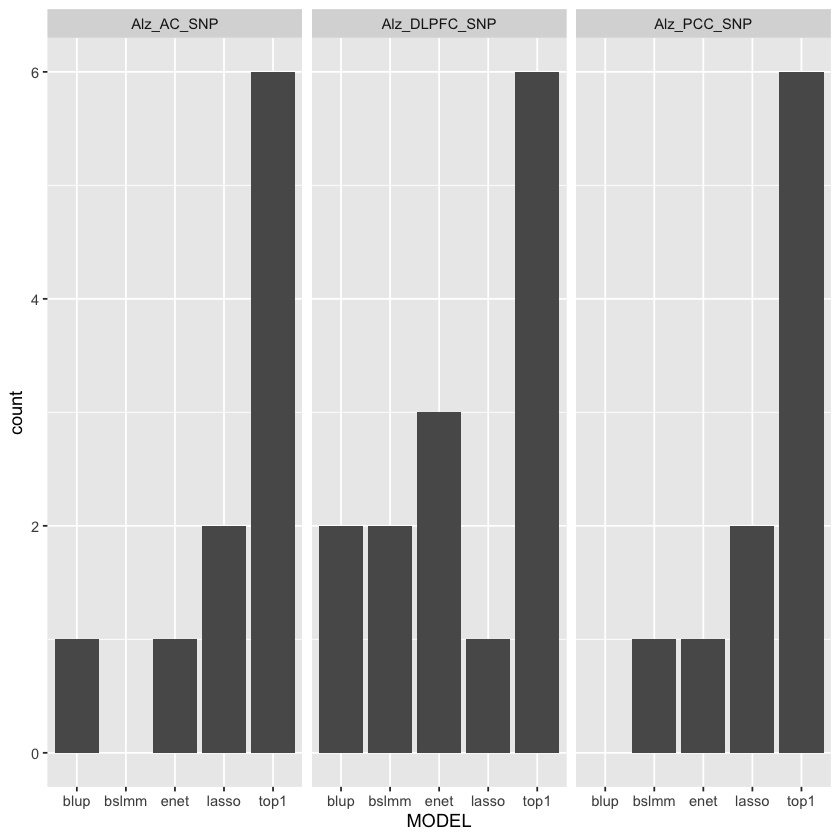

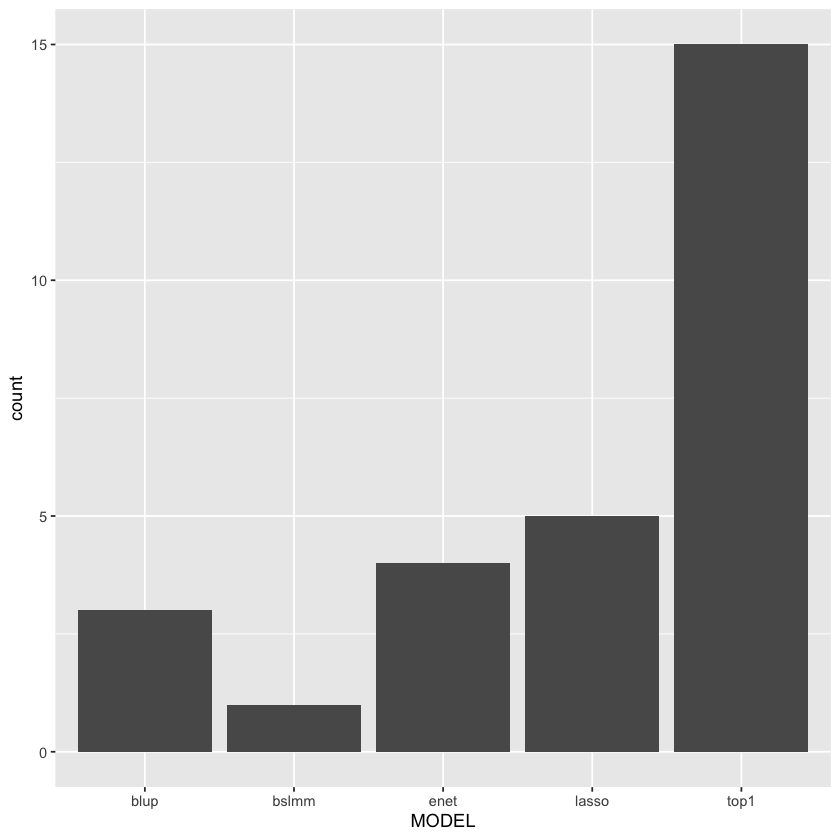

In [9]:
Top_TWAS_gene%>%mutate(TWAS.P = as.numeric(TWAS.P))%>%filter(TWAS.P < 0.05/45)%>%filter(str_detect(Proj_Name,"SNP"))%>%ggplot(aes(x = MODEL))+geom_bar()+facet_grid(~Proj_Name)
Top_TWAS_gene%>%mutate(TWAS.P = as.numeric(TWAS.P))%>%filter(TWAS.P < 0.05/45/3)%>%filter(str_detect(Proj_Name,"SNP"))%>%ggplot(aes(x = MODEL))+geom_bar()

### Heritability estimated by Fusion

In [7]:
analysis_susie%>%mutate(starting_gene = map_dbl(hsq_susie_data,~nrow(.x)), 
                        Convergence =  map_dbl(hsq_rw_data,~nrow(.x)),
                        Positivity =  map_dbl(hsq_data,~nrow(.x)),
                        Significance = map_dbl(result_data,~nrow(.x)),
                        CS = map_dbl(hsq_susie_data,~.x%>%filter(CS_size > 0)%>%nrow())
                        )%>%select(Proj_Name,starting_gene,Convergence,Positivity,Significance,CS)

Proj_Name,starting_gene,Convergence,Positivity,Significance,CS
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alz_AC_SNP,162,150,125,51,57
Alz_AC_FULL,162,154,127,54,55
Alz_DLPFC_SNP,162,148,129,41,56
Alz_DLPFC_FULL_2,162,78,54,29,55
Alz_PCC_SNP,160,147,106,43,38
Alz_PCC_Full,160,152,112,46,38


In [16]:
acting%>%filter(pval<0.01,heritability > 0, heritability<1)%>%filter(Proj_Name%>%str_detect("SNP"))%>%group_by(region)%>%count()%>%group_by(n)%>%summarise(gene_count = n())

`summarise()` ungrouping output (override with `.groups` argument)



n,gene_count
<int>,<int>
1,33
2,12
3,29


#### The distribution of average Hsq:
The mean of Hsq among the genes that passed the significance treshold is sysmetically a little bit higher than the Hsq compute by Susie in the tissues of  AC and DLPFC, but not the PCC. The variance of hsq estimated by susie is on par with that of the fusion.

In [8]:
# Sum stat for susie 
analysis_susie_sum = analysis_susie%>%unnest(cols = hsq_susie_data )%>%filter(CS_size > 0)%>%unnest(c(sum_hsq))%>%filter(data == "heritability")%>%group_by(Proj_Name)%>%summarise(Qt_hsq_susie = quantile(hsq_full_sample)%>%round( digits = 3)%>%paste(collapse = ","), n_hsq_susie = n(),mean_hsq_susie = mean(hsq_full_sample),var_hsq_susie =  var(hsq_full_sample),mean_hsq_naive = mean(hsq_naive))
# Sum stat for fusion
analysis_fusion_sum = analysis_susie%>%unnest(cols = hsq_data )%>%filter(pval < 0.01)%>%group_by(Proj_Name)%>%summarise(n_hsq = n(),mean_hsq = mean(heritability ),Qt_hsq = quantile(heritability )%>%round( digits = 3)%>%paste(collapse = ","),var_hsq = var(heritability ))
# Merge the two dataset
inner_join(analysis_susie_sum,analysis_fusion_sum)%>%select(Proj_Name,n_hsq_susie,n_hsq,mean_hsq_susie,mean_hsq,mean_hsq_naive,Qt_hsq_susie,Qt_hsq,var_hsq_susie,var_hsq)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "Proj_Name"



Proj_Name,n_hsq_susie,n_hsq,mean_hsq_susie,mean_hsq,mean_hsq_naive,Qt_hsq_susie,Qt_hsq,var_hsq_susie,var_hsq
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Alz_AC_FULL,55,54,0.1507397,0.1622208,0.1303161,"0.019,0.045,0.097,0.215,0.766","0.021,0.053,0.104,0.229,0.66",0.02467171,0.02344888
Alz_AC_SNP,57,51,0.1399740,0.1595784,0.1236560,"0.02,0.045,0.091,0.17,0.752","0.038,0.058,0.099,0.216,0.625",0.02271515,0.02167711
Alz_DLPFC_FULL_2,55,29,0.1299464,0.1560646,0.1152291,"0.019,0.034,0.064,0.16,0.788","0.017,0.066,0.119,0.172,0.558",0.02515941,0.01934301
Alz_DLPFC_SNP,56,50,0.1225468,0.1436298,0.1115788,"0.018,0.033,0.062,0.162,0.775","0.016,0.046,0.085,0.191,0.756",0.02257364,0.02546813
Alz_PCC_Full,38,46,0.1578710,0.1533610,0.1456015,"0.039,0.077,0.099,0.153,0.734","0.034,0.064,0.104,0.178,0.766",0.02813914,0.02289217
Alz_PCC_SNP,38,43,0.1550482,0.1524417,0.1434427,"0.04,0.073,0.101,0.151,0.736","0.034,0.06,0.104,0.18,0.684",0.02631249,0.02180619


#### Significant genes in each tissues's SNP data
The genes with a significant Fusion Hsq is not completly identicle with the genes that have a susie CS. As shown below. ~15 genes have only significant 

In [9]:
Venn(list(susie = t_susie%>%pull(region)%>%unique(), fusion = t_fusion%>%pull(region)%>%unique()))%>%ggvenn()

ERROR: Error in library.dynam(lib, package, package.lib): shared object ‘polyclip.dylib’ not found


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



An object of class "Venn"
Slot "sets":
$Set_1
[1] 1

$Set_2
[1] 2

$Set_3
[1] 3

$Set_4
[1] 4


Slot "names":
[1] "Set_1" "Set_2" "Set_3" "Set_4"


ERROR: Error: package or namespace load failed for ‘polyclip’ in library.dynam(lib, package, package.lib):
 shared object ‘polyclip.dylib’ not found


#### Overlap of credible sets
For each genes, each credible sets stands for the possible candidates of one of the SNVs that are responsible for the expression of the genes. To justify multivariate analysis, one should observed that the CS in each tissues shall not be be partially overlaped. Because a complete overlap stands for no difference across tissues while a none overlap stands for there is no similartiy among the tissues. Additional information can only be obtained by the partially overlap scenarios. 

Because each cs enssentially only indicating the potential candidates for one eQTL, pooling all the candidates together to form a CS inidicating all the possibile candidates for eQTL of particular genes shall be a valid operation. Therefore, All the SNVs in the CS of each tissues are pooled together.

Using the genes that have credible set for at least two tissues, the SNPs that are shared by all the tissues with availble tissues are shown as followed.

In [18]:
# This code block is what allowed the construction of the targeted data object
## susie filter by cs
Alz_gene = read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/Alz_gene_list.txt",delim = "\t")
a = attach("/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/cs.RData")
working = a$b%>%select(-path)
working = working%>%mutate(cs_po = map(cs,~unlist(.x)),
                           cs_name = map2(.x = env,.y = cs_po,~(.x$fitted1$lbf_variable%>%colnames())[.y])
                          )
gene_2cs = working%>%group_by(region)%>%count()%>%filter(n==2)%>%pull(region)
gene_3cs = working%>%group_by(region)%>%count()%>%filter(n==3)%>%pull(region)
temp = working%>%select(region,cs_po,cs,cs_name,Proj_Name,hsq_susie)%>%pivot_wider(names_prefix = "cs_",names_from = Proj_Name,values_from = c(hsq_susie,cs_po,cs_name,cs))
temp = temp%>%filter(region%in%c(gene_2cs,gene_3cs))
Venn_tbl = temp%>%mutate(Venn_cs = pmap(list(cs_name_cs_Alz_AC_SNP,cs_name_cs_Alz_PCC_SNP, cs_name_cs_Alz_DLPFC_SNP),function(first, second, third)(list(AC = first,PCC = second,DLPFC = third)%>%Venn())))
Venn_tbl  = Venn_tbl%>%mutate( 
  overlap = map(Venn_cs,~.x%>%overlap),
  perc_overlap = pmap_dbl(list(cs_name_cs_Alz_AC_SNP,cs_name_cs_Alz_PCC_SNP, cs_name_cs_Alz_DLPFC_SNP,overlap),function(first, second, third,forth)(length(forth)/length(c(first, second, third)%>%unlist()%>%unique()))),
#  Venn_diagram = map(Venn_cs,~.x%>%ggvenn),
  cs_name_cs_Alz_AC_SNP = cs_name_cs_Alz_AC_SNP%>%map(~.x%>%paste(collapse=",")),
  cs_name_cs_Alz_PCC_SNP = cs_name_cs_Alz_PCC_SNP%>%map(~.x%>%paste(collapse=",")),
  cs_name_cs_Alz_DLPFC_SNP = cs_name_cs_Alz_DLPFC_SNP%>%map(~.x%>%paste(collapse=",")))%>%unnest(cols = c(cs_name_cs_Alz_AC_SNP,cs_name_cs_Alz_PCC_SNP, cs_name_cs_Alz_DLPFC_SNP))
Venn_tbl = Venn_tbl%>%mutate(
  overl_c = map(overlap,~.x%>%paste(collapse=","))
)%>%unnest(overl_c)
Top_TWAS_gene_rf = Top_TWAS_gene%>%select(ID,gene,chr,logTWAS.P)%>%filter(str_detect(Proj_Name,"SNP"))%>%arrange(-logTWAS.P)%>%pivot_wider(names_prefix = "logTWAS.P_",names_from = Proj_Name,values_from = logTWAS.P)
result = inner_join(Top_TWAS_gene_rf,Venn_tbl,by = c("ID" ="region"))%>%arrange(-perc_overlap)%>%select(ID:cs_name_cs_Alz_PCC_SNP,overl_c,perc_overlap)%>%mutate(Three_tissues = ID%in%gene_3cs)

Parsed with column specification:
cols(
  gene = col_character(),
  ensembl_id = col_character(),
  chr = col_double()
)

Adding missing grouping variables: `Proj_Name`



In [22]:
## Showing the result
length(gene_3cs)
length(gene_2cs)
colnames(result)
result%>%select(ID,gene,'logTWAS.P_Alz_DLPFC_SNP','logTWAS.P_Alz_PCC_SNP','logTWAS.P_Alz_AC_SNP',Three_tissues,perc_overlap)%>%arrange(-perc_overlap)#%>%filter(perc_overlap >0,perc_overlap<1)


[1] 32

[1] 11

[1] "ID"                         "gene"                      
 [3] "chr"                        "logTWAS.P_Alz_DLPFC_SNP"   
 [5] "logTWAS.P_Alz_PCC_SNP"      "logTWAS.P_Alz_AC_SNP"      
 [7] "hsq_susie_cs_Alz_AC_SNP"    "hsq_susie_cs_Alz_DLPFC_SNP"
 [9] "hsq_susie_cs_Alz_PCC_SNP"   "cs_po_cs_Alz_AC_SNP"       
[11] "cs_po_cs_Alz_DLPFC_SNP"     "cs_po_cs_Alz_PCC_SNP"      
[13] "cs_name_cs_Alz_AC_SNP"      "cs_name_cs_Alz_DLPFC_SNP"  
[15] "cs_name_cs_Alz_PCC_SNP"     "overl_c"                   
[17] "perc_overlap"               "Three_tissues"

ID,gene,logTWAS.P_Alz_DLPFC_SNP,logTWAS.P_Alz_PCC_SNP,logTWAS.P_Alz_AC_SNP,Three_tissues,perc_overlap
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
ENSG00000161929,SCIMP,3.62160210,0.838631998,0.81211282,FALSE,1.00000000
ENSG00000099817,POLR2E,3.52143350,3.521433504,2.86012091,TRUE,1.00000000
ENSG00000007047,MARK4,3.01863449,NA,NA,TRUE,1.00000000
ENSG00000180448,HMHA1,1.85078089,0.906578315,NA,TRUE,1.00000000
ENSG00000264538,SUZ12P1,0.43062609,0.651695137,0.51533010,TRUE,1.00000000
ENSG00000073008,PVR,11.05998184,13.436518915,15.54515514,TRUE,0.85714286
ENSG00000214309,MBLAC1,NA,0.774690718,NA,TRUE,0.85000000
ENSG00000140416,TPM1,1.51855737,NA,1.29217443,FALSE,0.83333333
ENSG00000121716,PILRB,NA,0.442492798,NA,TRUE,0.77777778


In [25]:
#### To looks at the overlap between each genes of interest
gene_ID = "ENSG00000161929"
result%>%filter(ID %in%  gene_ID)%>%select(cs_name_cs_Alz_AC_SNP,cs_name_cs_Alz_DLPFC_SNP,cs_name_cs_Alz_PCC_SNP,overl_c)%>%t()


cs_name_cs_Alz_AC_SNP,"17:5124877_C_T,17:5125249_A_G,17:5125333_A_T,17:5126207_A_G,17:5126224_G_T,17:5126674_A_G,17:5128482_A_G,17:5133734_C_T,17:5133807_A_G,17:5134814_A_G"
cs_name_cs_Alz_DLPFC_SNP,
cs_name_cs_Alz_PCC_SNP,"17:5124877_C_T,17:5125249_A_G,17:5125333_A_T,17:5126207_A_G,17:5126224_G_T,17:5126674_A_G,17:5128482_A_G,17:5133734_C_T,17:5133807_A_G,17:5134814_A_G"
overl_c,"17:5124877_C_T,17:5125249_A_G,17:5125333_A_T,17:5126207_A_G,17:5126224_G_T,17:5126674_A_G,17:5128482_A_G,17:5133734_C_T,17:5133807_A_G,17:5134814_A_G"


#### Visualization of targeted genes
Since both ggvenn and susie R are not availble in jupyterLab, the following visualization are done in RStudio


In [ ]:
Venn_diag  = Venn_tbl%>%filter(region %in%  gene_ID)%>%mutate(Venn_diagram = map(Venn_cs,~.x%>%ggvenn))
working%>%filter(region %in%  gene_ID)%>%mutate(susie_plot = map(env,~.x$fitted1%>%susie_plot(y = "PIP",b = b)))
Venn_diag$Venn_diagram

#### Distribution of number of overlaped CS in each tissues
It turn out that most of the genes have only one overlapped CS, the only one with 2 CS is 

In [30]:
anchor = function(list,number){
  l = integer()
  for (i in list ){
    l = c(l, (sum(i%>%unlist() %in% number)>0))
  }
  return(list[l])
}

Venn_tbl_SNP = Venn_tbl%>%select(region,overlap)
Working = inner_join(working,Venn_tbl_SNP)
Working = Working%>%mutate(ovl_pos = map2(.x = env,.y = overlap,~which(.x$fitted1$mu%>%colnames() %in% .y) ))
cs_overl = Working%>%mutate(ovl_cs = map2(cs,ovl_pos,~anchor(.x,.y)),
                 n_ovl_cs = map_dbl(ovl_cs, ~length(.x)),
                p_ovl_cs  = n_ovl_cs/CS_size)
cs_overl%>%group_by(Proj_Name,n_ovl_cs)%>%summarise(n())
cs_overl%>%group_by(Proj_Name,CS_size)%>%summarise(n())
cs_overl%>%filter(n_ovl_cs == 1)%>%pull(region)%>%unique%>%length()

Joining, by = "region"

`summarise()` regrouping output by 'Proj_Name' (override with `.groups` argument)



Proj_Name,n_ovl_cs,n()
<chr>,<dbl>,<int>
Alz_AC_SNP,0,7
Alz_AC_SNP,1,32
Alz_AC_SNP,2,1
Alz_DLPFC_SNP,0,7
Alz_DLPFC_SNP,1,32
Alz_DLPFC_SNP,2,1
Alz_PCC_SNP,0,6
Alz_PCC_SNP,1,31
Alz_PCC_SNP,2,1


`summarise()` regrouping output by 'Proj_Name' (override with `.groups` argument)



Proj_Name,CS_size,n()
<chr>,<dbl>,<int>
Alz_AC_SNP,1,31
Alz_AC_SNP,2,6
Alz_AC_SNP,4,2
Alz_AC_SNP,5,1
Alz_DLPFC_SNP,1,29
Alz_DLPFC_SNP,2,7
Alz_DLPFC_SNP,3,2
Alz_DLPFC_SNP,4,1
Alz_DLPFC_SNP,7,1


[1] 35

In [27]:
(cs_overl%>%filter(n_ovl_cs == 2)%>%pull(region))[1]

[1] "ENSG00000196126"

In [35]:
result%>%filter(ID == "ENSG00000196126")%>%select(ID:hsq_susie_cs_Alz_PCC_SNP,'perc_overlap','Three_tissues')
colnames(result)

ID,gene,chr,logTWAS.P_Alz_DLPFC_SNP,logTWAS.P_Alz_PCC_SNP,logTWAS.P_Alz_AC_SNP,hsq_susie_cs_Alz_AC_SNP,hsq_susie_cs_Alz_DLPFC_SNP,hsq_susie_cs_Alz_PCC_SNP,perc_overlap,Three_tissues
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
ENSG00000196126,HLA-DRB1,6,3.277366,4.806875,2.732828,0.5356601,0.5554409,0.5969172,0.4434783,TRUE


[1] "ID"                         "gene"                      
 [3] "chr"                        "logTWAS.P_Alz_DLPFC_SNP"   
 [5] "logTWAS.P_Alz_PCC_SNP"      "logTWAS.P_Alz_AC_SNP"      
 [7] "hsq_susie_cs_Alz_AC_SNP"    "hsq_susie_cs_Alz_DLPFC_SNP"
 [9] "hsq_susie_cs_Alz_PCC_SNP"   "cs_po_cs_Alz_AC_SNP"       
[11] "cs_po_cs_Alz_DLPFC_SNP"     "cs_po_cs_Alz_PCC_SNP"      
[13] "cs_name_cs_Alz_AC_SNP"      "cs_name_cs_Alz_DLPFC_SNP"  
[15] "cs_name_cs_Alz_PCC_SNP"     "overl_c"                   
[17] "perc_overlap"               "Three_tissues"

## Association testing result
The association with the TWAS was produced using the following code.For the DLPFC, there are 22 skipped genes out of the 30 genes. Making a total of 8 genes with TWAS Z score.

For the PCC, there are 5 skipped gene out of six genes.

The error produced for the skipped genes is along the line of
>had 42 / 78 non-overlapping GWAS Z-scores, skipping this gene.

which stand for the fraction of snp in the WGS but not have a sums stat is larger than the  maximum fraction of SNPs allowed to be missing per gene (will be imputed using LD).


TODO：more in depth analysis, including both the strategy for future analysis.


In [1]:
a = tibble(a = 1 , b = 2)
read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/Alz/DLPFC/all_hsq.txt")



NameError: name 'tibble' is not defined

In [ ]:
# Supplementary
This section contains analysis that may provide insights.



In [ ]:
# To see what happened in the window of 500000
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_5E6/ \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  -J 10 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

In [ ]:
# To see what happened in the hsq cut off of 0.05
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_005_correct \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 10000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --asso_mem "60G" \
  --job_size 1\
  --hsq_p 0.05 \
  -J 10 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb association_test  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz \
  --genotype_list /home/hs3163/fake_Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/Alz_passed_gene_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 500000 \
  --container /home/hs3163/system_file/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --asso_mem "60G" \
  --job_size 1\
  --weights_list /home/hs3163/fake_weight_list.txt \
  -J 6 -q csg -c ~/GIT/neuro-twas/template/csg.yml -s build &

In [ ]:
library(dplyr)
library(plink2R)


wgt_list = read.table("/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/Alz/Alz_PCC_SNP/WEIGHTS/geneTpmResidualsAgeGenderAdj_rename.weights_list.txt",header = T)
wgt_list$WGT
chr = unique(wgt_list$CHR)
N = nrow(wgt_list)


wgt.file = paste(wgt_list$WGT[wgt_list$CHR == 7])
wgt.file ="/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/Alz/Alz_PCC_SNP/WEIGHTS/geneTpmResidualsAgeGenderAdj_rename.ENSG00000085514.wgt.RDat"
wgt_info = attach(wgt.file)

wgt_info$wgt.matrix[,]
wgt_info$wgt.matrix[,wgt_info$mod.best

row.pval = grep( "pval" , rownames(wgt_info$cv.performance) )
mod.best = which.min(apply(wgt_info$cv.performance[row.pval,,drop=F],2,min,na.rm=T))
cur.twasr2pred = wgt.matrix[,mod.best] %*% cur.LD %*% wgt.matrix[,mod.best]



wgt_info$wgt.matrix[,mod.best]


genos = read_plink("",impute="avg")
?read_plink
cur.LD = t(cur.genos) %*% cur.genos / (nrow(cur.genos)-1)


wgt_info


## CV

In [ ]:
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie_cv    --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt   --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt    --wd /home/hs3163/Project/Alz/Alz_AC_SNP_CV   --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt   --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt   --region_name 1   --data_start 2   --window 500000   --container /mnt/mfs/statgen/containers/twas_latest.sif   --model bslmm blup lasso top1 enet   --job_size 1  --asso_mem "6G"   --extract_snp ~/Project/Alz/data/AD_sumstats_SNP --cv_times 100  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

In [1]:
env = attach("/home/hs3163/Project/Alz/Alz_AC_SNP_CV/susie_cv.RData")

Attempting to load the environment ‘package:purrr’



In [3]:
data = env$output

In [10]:
data = env$output
working = data%>%select(-path)
working = working%>%mutate(
  n_of_cs = map_dbl(model,~.x$sets$cs_index%>%length()),
  total_cs_size = map_dbl(model,(~.x$sets$cs%>%unlist()%>%length())),
  mean_cs_size = total_cs_size/n_of_cs,
  rmse_ac = map_dbl(model,~.x$rmse),
  r2_ac = map_dbl(model,~.x$r2_raw),
  pval_ac = map_dbl(model,~.x$pval%>%round(3)),
)%>%select(ID,n_of_cs,rmse_ac,r2_ac,pval_ac)
  



In [17]:
working%>%filter(n_of_cs > 0 )%>%arrange(-r2_ac)

ID,n_of_cs,rmse_ac,r2_ac,pval_ac
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000198502,5,1.3726269,0.7575753579,0.000
ENSG00000179344,6,1.2201710,0.4886066724,0.000
ENSG00000196126,2,0.6949556,0.4826655401,0.000
ENSG00000196735,1,1.0089206,0.3158251758,0.000
ENSG00000213214,1,0.7814751,0.1953827954,0.000
ENSG00000104892,2,0.7851809,0.1906731502,0.000
ENSG00000134463,4,0.6809846,0.1890594161,0.000
ENSG00000121716,1,0.3922998,0.1886519024,0.000
ENSG00000065268,2,0.2730019,0.1706741551,0.001


# Citation
    1.Jansen IE, Savage JE, Watanabe K, Bryois J, Williams DM, Steinberg S, Sealock J, Karlsson IK, Hägg S, Athanasiu L, Voyle N, Proitsi P, Witoelar A, Stringer S, Aarsland D, Almdahl IS, Andersen F, Bergh S, Bettella F, Bjornsson S, Brækhus A, Bråthen G, de Leeuw C, Desikan RS, Djurovic S, Dumitrescu L, Fladby T, Hohman TJ, Jonsson PV, Kiddle SJ, Rongve A, Saltvedt I, Sando SB, Selbæk G, Shoai M, Skene NG, Snaedal J, Stordal E, Ulstein ID, Wang Y, White LR, Hardy J, Hjerling-Leffler J, Sullivan PF, van der Flier WM, Dobson R, Davis LK, Stefansson H, Stefansson K, Pedersen NL, Ripke S, Andreassen OA, Posthuma D. Genome-wide meta-analysis identifies new loci and functional pathways influencing Alzheimer’s disease risk  Nature Genetics, 2019 Mar;51(3):404-413. doi: 10.1038/s41588-018-0311-9

In [ ]:

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb association_test  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt \
  --wd /home/hs3163/Project/Alz_WG/mv_wg/wgt/DLPFC \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/mwe/mv_susie_mwe/region_list \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --weights_path /home/hs3163/Project/Alz_WG/mv_wg/wgt/DLPFC \
  --weights_list /home/hs3163/Project/Alz_WG/mv_wg/wgt/DLPFC/All_wgt_list.txt \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --job_size 1\
  --asso_mem "50G" \
  -J 40 -q csg -c /home/hs3163/GIT/neuro-twas/template/csg.yml \
  -s build &

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb association_test  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt \
  --wd /home/hs3163/Project/Alz_WG/mv_wg/wgt/PCC \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/mwe/mv_susie_mwe/region_list \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --weights_path /home/hs3163/Project/Alz_WG/mv_wg/wgt/PCC \
  --weights_list /home/hs3163/Project/Alz_WG/mv_wg/wgt/PCC/All_wgt_list.txt \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --job_size 1\
  --asso_mem "50G" \
  -J 40 -q neurology -c /home/hs3163/GIT/neuro-twas/template/csg.yml \
  -s build &

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb association_test  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt \
  --wd /home/hs3163/Project/Alz_WG/mv_wg/AC \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/mwe/mv_susie_mwe/region_list \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --weights_path /home/hs3163/Project/Alz_WG/mv_wg/AC \
  --weights_list /home/hs3163/Project/Alz_WG/mv_wg/AC/All_wgt_list.txt \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --job_size 1\
  --asso_mem "50G" \
  -J 40 -q csg -c /home/hs3163/GIT/neuro-twas/template/csg.yml \
  -s build &

Loading required package: Rcpp

Loading required package: RcppEigen

